In [1]:
# 1. Load Data ===
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Airbnb_Data.csv")

df['price_usd'] = np.exp(df['log_price'])

print("Dataset loaded and price restored from log_price.")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
display(df.head())

Dataset loaded and price restored from log_price.
Shape: 74111 rows × 30 columns


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,price_usd
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,150.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,169.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,145.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,750.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0,115.0


In [2]:
# 2. Handle Missing Values (Imputation using mean/mode)
missing = df.isnull().mean().sort_values(ascending=False)
print("Missing Value Ratio (%):")
display((missing * 100).round(2))

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values imputed with mean/mode.")
print(f"Remaining missing values: {df.isnull().sum().sum()} (should be 0)")


Missing Value Ratio (%):


,0
host_response_rate,24.69
review_scores_rating,22.56
first_review,21.41
last_review,21.36
thumbnail_url,11.09
neighbourhood,9.27
zipcode,1.30
bathrooms,0.27
host_identity_verified,0.25
host_since,0.25


Missing values imputed with mean/mode.
Remaining missing values: 0 (should be 0)


In [3]:
# 3. Outlier Detection (Z-score method, |Z| ≤ 3)
z_scores = np.abs(stats.zscore(df['price_usd']))
df_clean = df[z_scores <= 3]

print(f"Before removing outliers: {len(df)} rows")
print(f"After removing outliers: {len(df_clean)} rows")
print(f"📉 Removed {(1 - len(df_clean)/len(df)) * 100:.2f}% extreme outliers")

Before removing outliers: 74111 rows
After removing outliers: 72518 rows
📉 Removed 2.15% extreme outliers


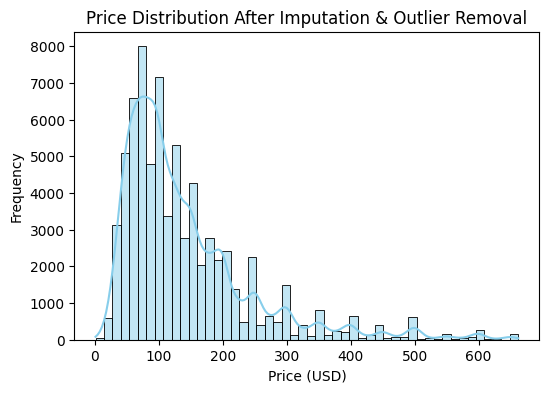

In [4]:
# 4. Visualize cleaned data
plt.figure(figsize=(6,4))
sns.histplot(df_clean['price_usd'], bins=50, kde=True, color="skyblue")
plt.title("Price Distribution After Imputation & Outlier Removal")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.show()

In [5]:
# 5. Baseline Model: OLS Regression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df_ml = df_clean.copy()

df_ml["bedrooms_sq"] = df_ml["bedrooms"] ** 2
df_ml["bathrooms_sq"] = df_ml["bathrooms"] ** 2
df_ml["interaction_bb"] = df_ml["bedrooms"] * df_ml["bathrooms"]
df_ml = pd.get_dummies(df_ml, columns=["city", "room_type"], drop_first=True, dtype=float)
df_ml["log_price"] = df_ml["log_price"] if "log_price" in df_ml.columns else np.log1p(df_ml["price_usd"])

base_features = [
    "bedrooms", "bathrooms", "accommodates", "review_scores_rating",
    "bedrooms_sq", "bathrooms_sq", "interaction_bb"
]
dummy_features = [col for col in df_ml.columns if col.startswith(("city_", "room_type_"))]
features = base_features + dummy_features

df_ml = df_ml.replace([np.inf, -np.inf], np.nan).dropna(subset=features + ["log_price"])

X = df_ml[features]
y = df_ml["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)
ols_model = sm.OLS(y_train, X_train_const).fit()

print(ols_model.summary())
y_pred_ols = ols_model.predict(X_test_const)
print(f"\nTrain R²: {ols_model.rsquared:.3f}")
print(f"Test R²: {r2_score(y_test, y_pred_ols):.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_ols):.3f}")


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     4274.
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        04:32:27   Log-Likelihood:                -30636.
No. Observations:               50762   AIC:                         6.130e+04
Df Residuals:                   50747   BIC:                         6.143e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

In [6]:
# 6. Elastic Net
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error

enet = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=None, cv=5, n_jobs=-1, random_state=42)
enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)

print("=== Elastic Net ===")
print(f"Best l1_ratio: {enet.l1_ratio_:.3f}, Best alpha: {enet.alpha_:.5f}")
print(f"Test R²: {r2_score(y_test, y_pred_enet):.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_enet):.3f}")


=== Elastic Net ===
Best l1_ratio: 0.900, Best alpha: 0.00104
Test R²: 0.541
Test MSE: 0.194


=== Random Forest Regression Results ===
Train R²: 0.599
Test  R²: 0.573
Test  MSE: 0.181


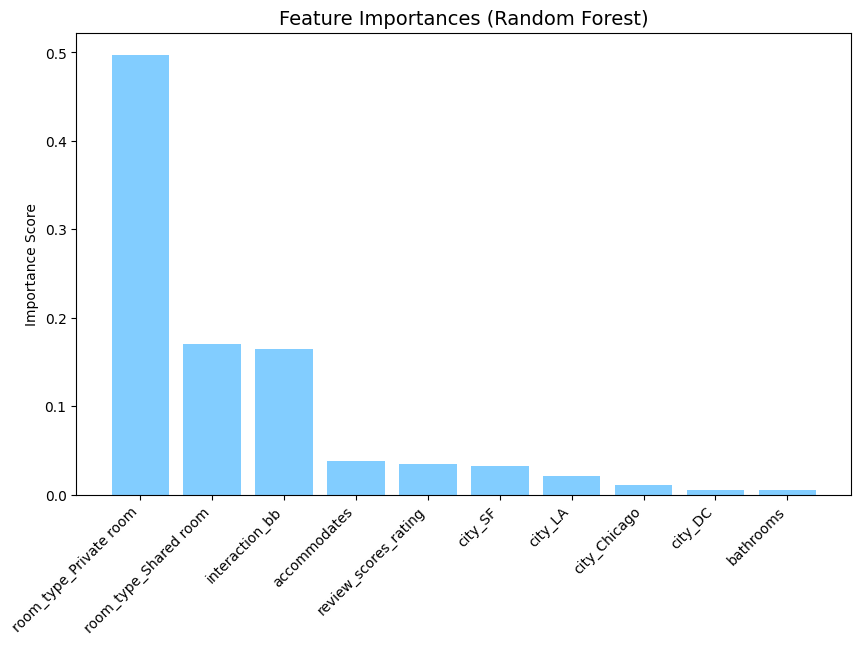

In [7]:
# 7. Advanced Model: Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

SEED = 42

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=SEED,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

r2_train = rf_model.score(X_train, y_train)
r2_test = r2_score(y_test, y_pred_rf)
mse_test = mean_squared_error(y_test, y_pred_rf)

print("=== Random Forest Regression Results ===")
print(f"Train R²: {r2_train:.3f}")
print(f"Test  R²: {r2_test:.3f}")
print(f"Test  MSE: {mse_test:.3f}")

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)", fontsize=14)
plt.bar(range(top_n), importances[indices[:top_n]], color="#4db8ff", alpha=0.7)
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.show()

=== XGBoost Regression Results ===
Train R²: 0.601
Test  R²: 0.579
Test  MSE: 0.178


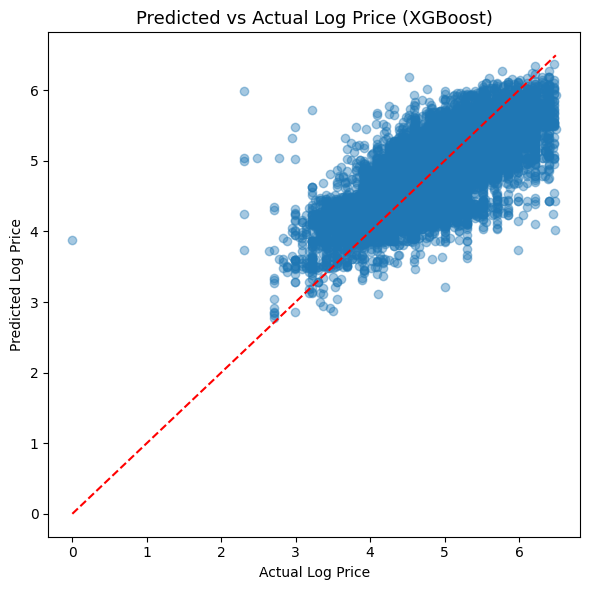

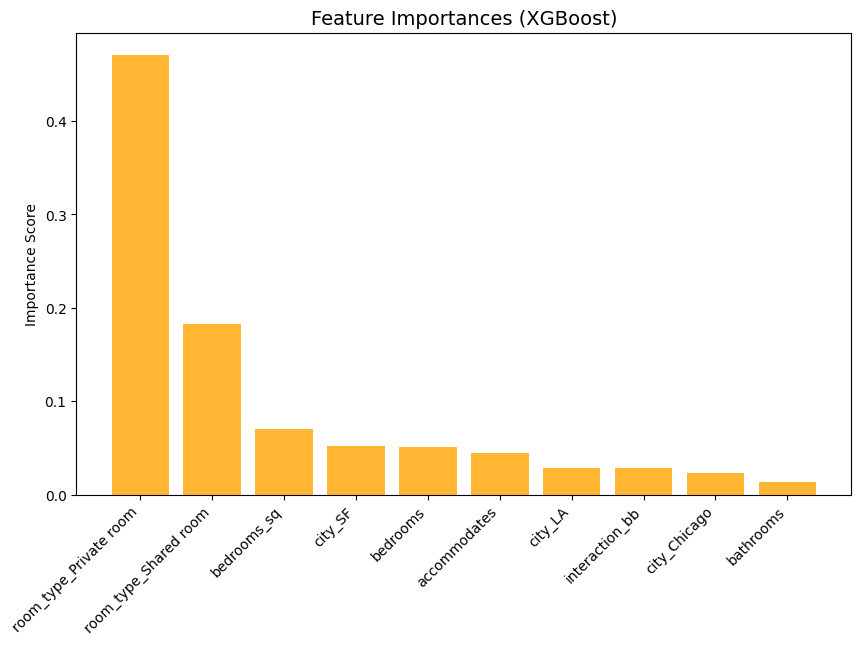

In [8]:
# 8. Advanced Model 2: XGBoost Regression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

SEED = 42

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    reg_lambda=1.0,
    n_jobs=-1,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
r2_train_xgb = xgb_model.score(X_train, y_train)
r2_test_xgb  = r2_score(y_test, y_pred_xgb)
mse_test_xgb = mean_squared_error(y_test, y_pred_xgb)

print("=== XGBoost Regression Results ===")
print(f"Train R²: {r2_train_xgb:.3f}")
print(f"Test  R²: {r2_test_xgb:.3f}")
print(f"Test  MSE: {mse_test_xgb:.3f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.4, color="#1f77b4")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Log Price (XGBoost)", fontsize=13)
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.tight_layout()
plt.show()

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)", fontsize=14)
plt.bar(range(top_n), importances[indices[:top_n]], color="#ffa500", alpha=0.8)
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.show()